## Project 2: Feature Detection and Matching
### Gabriel Hofer  
### CSC-414 Introduction to Computer Vision  
### Instructor: Dr. Randy C. Hoover  

### Introduction

I used Harris Corner detection for calculating keypoints
I used SIFT to create descriptors.
My matching algorithm uses the orientation and magnitude of
the descriptors as matching criteria.
I wrote three functions for showing keypoints, descriptors, and feature matches.
They are: showKeypoints, showFeatures, drawMatches

### Contents  
1. Introduction
2. Gaussian Kernel
3. Harris Corner Detector
4. SIFT Feature Descriptor
5. Feature Matching of Descriptors
6. Show Keypoints, Show Descriptors
7. Draw Lines Between Matches
8. Demo Function
9. Running the Demo on pairs of images
---  

### Gaussian Kernel
param r - number of rows  
param c - number of columns  
param s - sigma  
returns 2d numpy array, the gaussian kernel  

In [8]:
import numpy as np
import math
def gk(r,c,s):
	arr=np.zeros((r,c))
	for i in range(r):
		for j in range(c):
			arr[i,j]=(1/(2*math.pi*s*s))*math.exp(-1*((i-r//2)*(i-r//2)+(j-c//2)*(j-c//2))/(2*s*s))
	return arr


### Harris Corner Detector  
Harris Corner Detection algorithm  
:param img - image, numpy array  
:param g - square guassian matrix, w  
:th - threshold value for R  
:returns - list of pairs. each pair is coordinates of an interst point, (x,y)  

In [9]:
import numpy as np
import scipy.signal as ss

xsobel = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]])

ysobel = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]])

def harris(img,g,th):
    n=g.shape[0]
    x=ss.convolve2d(img,xsobel)
    y=ss.convolve2d(img,ysobel)    
    xx=x*x
    yy=y*y
    xy=x*y
    r,c=img.shape[0],img.shape[1]
    avgR=0
    R=125
    feat=[]
    for i in range(r-n):
        for j in range(c-n):
            sxx=(g*xx[i:i+n, j:j+n]).sum()
            syy=(g*yy[i:i+n, j:j+n]).sum()
            sxy=(g*xy[i:i+n, j:j+n]).sum()
            d=(sxx*syy)-(sxy*sxy) 
            t=sxx+syy
            if t!=0:
                R = d/t
            avgR+=R
            if R>th: 
                if i>10 and i<r-10 and j>10 and j<c-10:
                    feat.append([i,j])
    avgR/=r*c
    print("average r: "+str(avgR))
    return feat


### printH
Used for printing histogram bins, for debugging


### makeH
:returns orientation and magnitude pair 

### Sift Feature Desciptor
Description: A SIFT descriptor is created for each keypoint/feature. Let the location of any keypoint be x,y. Consider a 16x16 window around this keypoint. Next, we break this 16x16 window into 16 smaller 4x4 windows. For each of these smaller windows, a histogram is created by calling the makeH function. Histograms are implemented/represented as 8-bin arrays. The bin with the greatest value determines the orientation/angle/gradient of the 4x4 sub-window. makeH returns both the orientation and magnitude of this smaller window. makeH is called 16 times in total for a keypoint. Once 16 histograms have been made for a single keypoint, another histogram is created to combine the 16 histograms. Once again, the bin with the greatest value determines the orientation and magnitude of the keypoint. 

:param img - image  
:param feat - list of interest points a.k.a. keypoints  
:returns list of descriptors, [(theta,magnitude)]  


In [3]:
import numpy as np
from gk import gk
import math

def printH(H):
    for i in H: print(str(i)+' ',end='')
    print()

def makeH(W):
    H=np.zeros(8)
    for i in range(1,5):
        for j in range(1,5):
            m = math.sqrt((W[i+1,j]-W[i-1,j])**2 + (W[i,j+1]-W[i,j-1])**2)
            if W[i,j+1] != W[i,j-1] and W[i+1,j] != W[i-1,j]: 
                theta = math.atan2((W[i+1,j]-W[i-1,j]), (W[i,j+1]-W[i,j-1]))
            else: continue
            norm=int(math.floor((theta+math.pi)*8/(2*math.pi))%8)
            H[norm]+=m
    m=0
    theta=-1
    for i,j in enumerate(H):
        if j>m:
            m=j
            theta=i
    return [theta,m]

def sift(img,feat):
    print("shape of img: "+str(img.shape))

    sift=[]
    tmp=[]
    for f in feat:
        if f[0]>8 and f[0]<img.shape[0]-8 and f[1]>8 and f[1]<img.shape[1]-8:
            tmp.append(f)
    feat=tmp
    for i in feat:
        r,c=i[0],i[1]
        A=np.zeros((4,4,2)) 
        for j in range(4):
            for k in range(4):
                A[j,k]=makeH(gk(6,6,1)*img[r-9+(j*4):r-3+(j*4),c-9+(k*4):c-3+(k*4)])
        B=np.zeros(8)
        for j in range(4):
            for k in range(4):
                B[int(A[j,k,0])]+=A[j,k,1]
        m=0
        theta=-1
        for i,j in enumerate(B):
            if j>m:
                m=j
                theta=i
        sift.append((theta,m))
    return sift


### Matching  
Matches SIFT descriptors using two threshold values for comparing
similar orientations and magnitudes. Moreover, two descriptors whose 
orientations and magnitudes differ by less than their respective thresholds 
will be matched.

:param d0 - descriptor list  
:param d1 - descriptor list  
:param theta_th - threshold for comparing orientation of descriptors  
:param mag_th - threshold for comparing magnitude of descriptors  


In [4]:

def matchSIFT(d0,d1,theta_th,mag_th):
    matches=[]
    for idxi, i in enumerate(d0):
        for idxj, j in enumerate(d1):
            if abs(i[0]-j[0])<=theta_th and abs(i[1]-j[1])<=mag_th:
                matches.append([idxi,idxj])
    return matches


### Show Features  
description: displays a red square depicting the dominant orientation.

param loc: [x,y] - location  
param scale - scale that the feature was detected at  
param orient - dominant orientation  
return - returns nothing. overlays feature locations on top of the image  


In [5]:

from skimage import io
import cv2
import numpy as np
import math

def showFeatures(img,loc,D):
    print("lenth of loc and D: "+str(len(loc))+" , "+str(len(D)))


    for p in range(min(len(loc),len(D))):
        r,c=loc[p]
        dr=D[p][0]
        if D[p][0]%2==0:
            #something
            for j in range(11):
                img[r-j,c-11+j]=[255,0,0]
                img[r+j,c+11-j]=[255,0,0]
                img[r-11+j,c+j]=[255,0,0]
                img[r+11-j,c-j]=[255,0,0]
        else:
            #something else
            for j in range(-7,8):
                img[r+j,c+8,:]=[255,0,0]
                img[r+j,c-7,:]=[255,0,0]
                img[r+8,c+j,:]=[255,0,0]
                img[r-7,c+j,:]=[255,0,0]

        if dr==0:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==1:
            for j in range(7):
               img[r-j,c+j]=[255,0,0]
        if dr==2:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==3:
            for j in range(7):
                img[r-j,c-j]=[255,0,0]
        if dr==4:
            for j in range(7):
               img[r+j,c-j]=[255,0,0]
        if dr==5:
            for j in range(7):
                img[r+j,c+j]=[255,0,0]
        if dr==6:
            for j in range(7):
               img[r+j,c+j]=[255,0,0]
        if dr==7:
            for j in range(7):
                img[r+j,c+j]=[255,0,0]
    #io.imshow((img * 255).astype(np.uint8)  , vmin=0, vmax=255, cmap="gray")
    io.imshow(img,vmin=0,vmax=255)
    io.show()
    

### Show Keypoints
Description: Simply paints a red dot at the keypoint in the image.

In [6]:
"""
description: displays a red square depicting the dominant orientation.
param loc: [x,y] - location
param scale: scale that the feature was detected at
param orient: dominant orientation
return: returns nothing. overlays feature locations on top of the image
"""
from skimage import io
import cv2
import numpy as np
def showKeypoints(img,feat):
    for i in feat:
        img[i[0],i[1],:]=[255,0,0]
    #io.imshow((img * 255).astype(np.uint8)  , vmin=0, vmax=255, cmap="gray")
    io.imshow(img,vmin=0,vmax=255)
    io.show()


### line1
Description - draws a blue line 

:param img - image  
:param one - (x0,y0)  
:param two - (x1,y1)  
:param c - color  
  
### drawMatches  
Description - draws lines between matching descriptors 

:param img0 - image 1  
:param kp0 - keypoints 1  
:param img1 - image 2  
:param kp1 - keypoints 2  
:param matches - matches keypoints  

In [18]:
import cv2
import math
import numpy as np
from showKeypoints import showKeypoints 
from skimage import io


def line1(img,one,two,c):
    x0,y0=one
    x1,y1=two
    if y0==y1: return
    dx=x1-x0
    dy=y1-y0
    step=max(abs(dx),abs(dy))
    dx/=step
    dy/=step
    x=x0
    y=y0
    i=0
    while i<step:
        img[int(x),int(y)]=c
        x+=dx
        y+=dy
        i+=1

def drawMatches(img0,kp0,img1,kp1,matches):
    img2 = np.zeros((
        max(img0.shape[0],img1.shape[0]),
        img0.shape[1]+img1.shape[1],
        3),np.uint(8))
    img2[0:img0.shape[0],0:img0.shape[1]] = img0
    img2[0:img1.shape[0],img0.shape[1]:img0.shape[1]+img1.shape[1]] = img1
    nkp1=[] # translate coordinate of right image
    for i in range(len(kp1)):
        nkp1.append([kp1[i][0],img0.shape[1]+kp1[i][1]])
    for [i,j] in matches:
        one,two = kp1[i], nkp1[j]
        line1(img2,one,two,[0,0,255])
    return img2




### Demo Function

Demo generates keypoints, descriptors, matches descriptors, and draws features and matches.

:param imgfile0 - name of file containing image 1  
:param imgfile1 - name of file containing image 2  
:param rth0 - threshold for r0 in harris corner detector  
:param rth1 - threshold for r1 in harris corner detector  
:param mth - magnitude threshold in matching function  

In [2]:
from gk import gk
from harris import harris
from showKeypoints import showKeypoints
import numpy as np
import sys
from skimage import io
from skimage.color import rgb2gray
from showFeatures import showFeatures
from sift import printH, makeH, sift
from matching import matchSIFT
import cv2
from drawMatches import drawMatches


def demo(imgfile0,imgfile1,rth0,rth1,mth):
    # read image, convert to gray
    #img = io.imread(sys.argv[1]);
    img=io.imread("data/plane.bmp")
    img0 = io.imread(imgfile0)
    img1 = io.imread(imgfile1)

    print("orig0 shape: "+str(img0.shape))
    print("orig1 shape: "+str(img1.shape))

    gry0 = rgb2gray(img0)
    gry1 = rgb2gray(img1)

    print("gray0 shape: "+str(gry0.shape))
    print("gray1 shape: "+str(gry1.shape))
    
    # get list of locations of interest points
    feat0 = harris(gry0,gk(3,3,1),rth0)
    feat1 = harris(gry1,gk(3,3,1),rth1)

    print("number of features0: "+str(len(feat0)))
    print("number of features1: "+str(len(feat1)))
    
    # make sift descriptors
    des0 = sift(gry0,feat0)
    des1 = sift(gry1,feat1)
    
    showFeatures(img0,feat0,des0)
    showFeatures(img1,feat1,des1)
    
    M = matchSIFT(des0,des1,40,mth)
    
    img2 = drawMatches(img0,feat0,img1,feat1,M)
    
    io.imshow( img2,vmin=0,vmax=255,cmap="gray")
    io.show()
    


/home/gabe/.local/lib/python3.6/site-packages/ipykernel_launcher.py
orig0 shape: (2048, 1536, 3)
orig1 shape: (2032, 1524, 3)
gray0 shape: (2048, 1536)
gray1 shape: (2032, 1524)
average r: 0.005974807670293086
average r: 0.006487333962416667
number of features0: 325
number of features1: 732
shape of img: (2048, 1536)
shape of img: (2032, 1524)
lenth of loc and D: 325 , 325


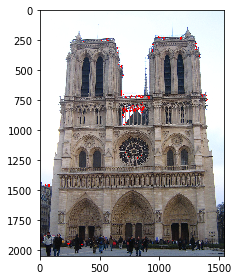

lenth of loc and D: 732 , 732


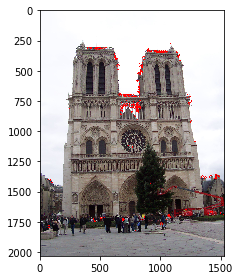

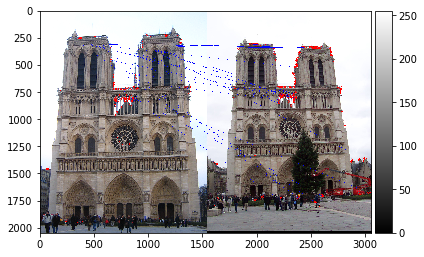

orig0 shape: (2112, 2816, 3)
orig1 shape: (1944, 2592, 3)
gray0 shape: (2112, 2816)
gray1 shape: (1944, 2592)
average r: 0.0034933392829465475
average r: 0.0013105174488298905
number of features0: 4305
number of features1: 2897
shape of img: (2112, 2816)
shape of img: (1944, 2592)
lenth of loc and D: 4305 , 4305


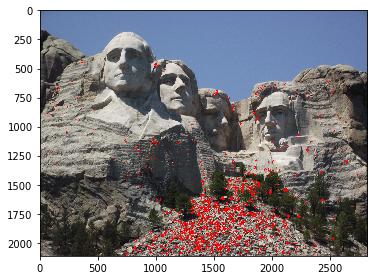

lenth of loc and D: 2897 , 2897


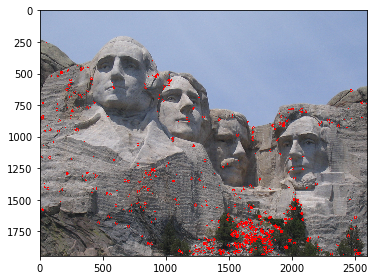

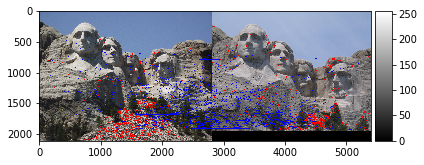

orig0 shape: (1801, 2701, 3)
orig1 shape: (1200, 1600, 3)
gray0 shape: (1801, 2701)
gray1 shape: (1200, 1600)
average r: 0.016337253263482274
average r: 0.004363083297666547
number of features0: 754
number of features1: 323
shape of img: (1801, 2701)
shape of img: (1200, 1600)
lenth of loc and D: 754 , 754


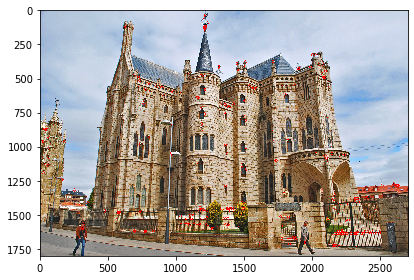

lenth of loc and D: 323 , 323


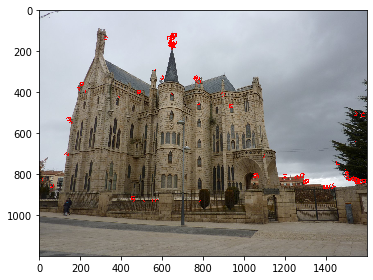

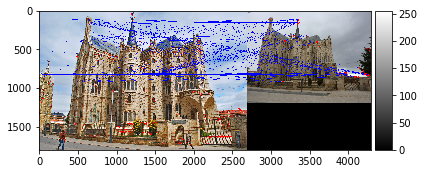

In [3]:
import sys
from demo import demo

print(sys.argv[0])
demo("data/notredame/notre_dame_1.jpg","data/notredame/notre_dame_2.jpg",0.5,0.5,0.0001)
demo("data/rushmore/rush1.jpg","data/rushmore/rush0.jpg",0.12,0.04,0.00001)
demo("data/gaudi/gaudi_1.jpg","data/gaudi/gaudi_2.jpg",0.7,0.3,0.001)

#demo("data/plane.bmp","data/plane.bmp")
#demo(sys.argv[1],sys.argv[2],.5,.5,0.0001)


### Conclusion
My match function seems to be fairly inaccurate.